In [87]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


factors = pd.read_excel('factor_pricing_data.xlsx', 'factors (excess)').set_index("Date")
assets = pd.read_excel('factor_pricing_data.xlsx', 'assets (excess)').set_index("Date")


In [88]:
print('*** Factor Data ***')
display(factors.head())
print(' ')
print('*** Portfolio Data ***')
display(assets.head())


*** Factor Data ***


,MKT,SMB,HML,UMD
Date,,,,
1990-01-31,-0.079,-0.013,0.009,-0.033
1990-02-28,0.011,0.010,0.006,-0.005
1990-03-31,0.018,0.015,-0.029,0.018
1990-04-30,-0.034,-0.005,-0.026,0.024
1990-05-31,0.084,-0.026,-0.038,0.030


 
*** Portfolio Data ***


,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1990-01-31,-0.100,-0.044,-0.062,-0.049,-0.086,-0.018,-0.140,-0.059,-0.070,-0.079,-0.103,-0.079
1990-02-28,-0.010,0.046,0.021,0.025,0.016,0.035,-0.009,-0.004,0.014,-0.026,0.018,0.024
1990-03-31,0.039,0.023,0.040,-0.012,0.016,0.038,0.035,-0.014,0.045,0.032,-0.022,0.013
1990-04-30,-0.010,-0.047,-0.036,-0.042,-0.029,-0.027,-0.042,-0.062,-0.028,-0.004,-0.049,-0.029
1990-05-31,0.084,0.071,0.071,0.053,0.082,0.119,0.087,0.047,0.110,0.121,0.086,0.082


# 2 Pricing Factors and Assets

1. The Factors. Calculate their univariate performance statistics:


• mean

• volatility

• Sharpe

• VaR(.05)


Does each factor have a premium (positive expected excess return)

In [100]:


factors_ann_mean = factors.mean(axis=0, numeric_only=True) * 12
factors_ann_vol = factors.std(axis=0, numeric_only=True) * np.sqrt(12)
factors_ann_sharpe = factors_ann_mean / factors_ann_vol * np.sqrt(12)
factors_VaR = factors.quantile(0.05)

print ("Annualized:")
factors_ann_sum_stats = pd.DataFrame({'Ann Mean': factors_ann_mean, 'Ann Vol': factors_ann_vol, 'Ann Sharpe' : factors_ann_sharpe, 'VaR(.05)': factors_VaR})
factors_ann_sum_stats.style



Annualized:


,Ann Mean,Ann Vol,Ann Sharpe,VaR(.05)
MKT,0.084331,0.151860,1.923687,-0.076485
SMB,0.012124,0.109577,0.383270,-0.042925
HML,0.018235,0.111001,0.569079,-0.041590
UMD,0.057374,0.163416,1.216226,-0.071160


In [90]:

factors_mean = factors.mean(axis=0, numeric_only=True)
factors_vol = factors.std(axis=0, numeric_only=True) 
factors_sharpe = factors_mean / factors_vol 

print ("Non-annualized:")
factors_sum_stats = pd.DataFrame({'Mean': factors_mean, 'Vol': factors_vol, 'Sharpe' : factors_sharpe, 'VaR(.05)': factors_VaR})
factors_sum_stats.style

Non-annualized:


,Mean,Vol,Sharpe,VaR(.05)
MKT,0.007028,0.043838,0.160307,-0.076485
SMB,0.001010,0.031632,0.031939,-0.042925
HML,0.001520,0.032043,0.047423,-0.041590
UMD,0.004781,0.047174,0.101352,-0.071160


Yes, each factor has a premium because each of their means is positive.

2. The factors are constructed in such a way as to reduce correlation between them.
Report the correlation matrix across the three factors. Does the construction method succeed
in keeping correlations small?

**** Correlation Matrix ****


,MKT,SMB,HML,UMD
MKT,1.000,0.242,-0.132,-0.280
SMB,0.242,1.000,-0.221,0.007
HML,-0.132,-0.221,1.000,-0.230
UMD,-0.280,0.007,-0.230,1.000


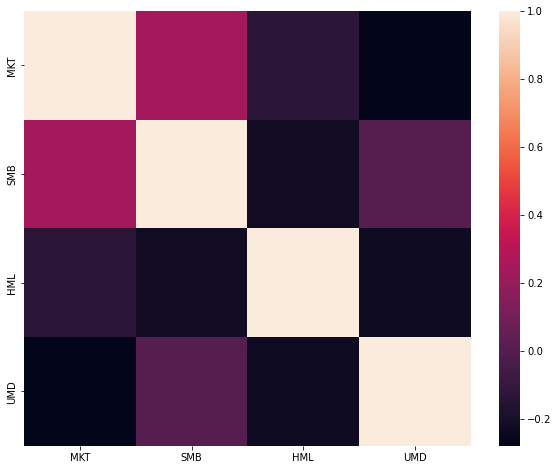

Factors with highest correlation: ('UMD', 'MKT')
Factors with lowest correlation: ('UMD', 'SMB')


In [91]:
corrmat = factors.corr()
print('**** Correlation Matrix ****')
display(corrmat)

plt.figure(figsize=(10,8))
sns.heatmap(corrmat)
plt.show()

corrmat[corrmat==1] = None

corr_rank = abs(corrmat.unstack()).sort_values(ascending = False).dropna()

print('Factors with highest correlation: ' + str(corr_rank.index[1]))
print('Factors with lowest correlation: ' + str(corr_rank.index[-1]))

Yes, the factors have low correlations. We can see that all the correlations have absolute value value less than 0.3, and many are even negatively correlated. Qualitatively speaking, these values are quite close to zero, and this is much lower correlation than we have seen when comparing different assets/securities before. 

3. Plot the cumulative returns of the factors.

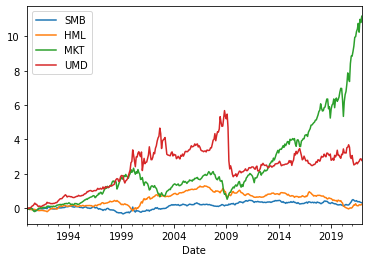

In [92]:

cum_rets = (1+factors).cumprod() - 1

cum_rets[['SMB', 'HML', 'MKT', 'UMD']].loc[:'2021'].plot()
plt.show()



4. Test assets.

The “assets” tab provides monthly excess return data on various industry stock-portfolios.

Denote these as ri, for n = 1,...,12.

Calculate the (annualized) univariate statistics from 1.1

In [101]:
assets_ann_mean = assets.mean(axis=0, numeric_only=True) * 12
assets_ann_vol = assets.std(axis=0, numeric_only=True) * np.sqrt(12)
assets_ann_sharpe = assets_ann_mean / assets_ann_vol * np.sqrt(12)
assets_VaR = assets.quantile(0.05)

assets_ann_sum_stats = pd.DataFrame({'Mean': assets_ann_mean, 'Vol': assets_ann_vol, 'Sharpe' : assets_ann_sharpe, 'VaR(.05)': assets_VaR})
assets_ann_sum_stats.style


,Mean,Vol,Sharpe,VaR(.05)
NoDur,0.085781,0.131829,2.254098,-0.057325
Durbl,0.106454,0.270225,1.364665,-0.112125
Manuf,0.101038,0.184678,1.895230,-0.084080
Enrgy,0.087028,0.220138,1.369474,-0.095495
Chems,0.085880,0.147866,2.011943,-0.071560
BusEq,0.124859,0.235254,1.838536,-0.111065
Telcm,0.054792,0.175183,1.083465,-0.089795
Utils,0.075019,0.138273,1.879417,-0.062895
Shops,0.096755,0.160510,2.088145,-0.071895
Hlth,0.097002,0.153318,2.191683,-0.072780


5. Can the difference in mean excess returns of the portfolios be explained by differences in their
volatilities? Or by their VaR(.05) statistics?

No. As Shown in the two scatter plots below (vol vs mean and VaR vs mean), there is no linear relationship between either of those factors and excess returns. 

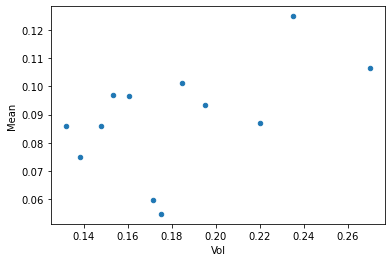

TypeError: cannot perform reduce with flexible type

In [105]:
assets_ann_sum_stats.plot.scatter('Vol', 'Mean')
plt.show()

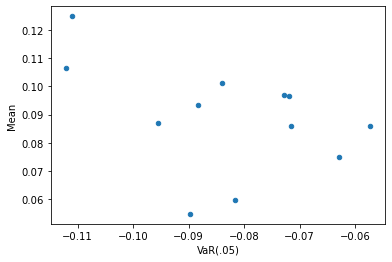

In [95]:
assets_ann_sum_stats.plot.scatter('VaR(.05)', 'Mean')
plt.show()

# 3 CAPM


1. For each of the n = 12 test assets, run the CAPM time-series regression:
 ̃ri
t = αi + βi,mkt  ̃fmkt
t + i
t
So you are running 12 separate regressions, each using the T-sized sample of time-series data

2. Report the estimated βi,mkt, Treynor Ratio, αi, and Information Ratio for each of the n regres-
sions.

In [96]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg


In [97]:
coef_table = get_ols_metrics(factors['MKT'], portfolios, annualization=1, ignorenan=True)
display(coef_table)


,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,0.003,0.631,0.529,0.011,0.104
Durbl,-0.001,1.361,0.585,0.007,-0.014
Manuf,0.001,1.103,0.823,0.008,0.030
Enrgy,0.001,0.844,0.339,0.009,0.026
Chems,0.002,0.766,0.619,0.009,0.067
BusEq,0.001,1.335,0.743,0.008,0.030
Telcm,-0.002,0.924,0.642,0.005,-0.064
Utils,0.003,0.409,0.202,0.015,0.095
Shops,0.002,0.894,0.716,0.009,0.072
Hlth,0.003,0.721,0.510,0.011,0.097


3. If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?



The alphas would be zero because otherwise there would be excess return that is not explained by correlation to the market.
The treynor ratios would all be the same because CAPM implies that expected return is proportionate to market risk.

Information ratio should be zero because alpha is zero.




In [98]:
alpha_mean=coef_table.alpha.abs().mean()
print ("MAE: ")
print(alpha_mean)

MAE: 
0.00173232537984283


4. Calculate the mean-absolute-error of the estimated alphas, (one for each security,  ̃ri.)
MAE = 1
n
n∑
i=1
|ˆαi|
If the pricing model worked, should these alpha estimates be large or small? Why? Based on
your MAE stat, does this seem to support the pricing model or not?

If CAPM worked, these estimates should be small because otherwise there would be an excess that cannot be explained by market beta. CAPM seems to be imperfect because MAE is not exactly zero, but it does appear to work somewhat because the value of 0.0017 is still very small.

# 4 a multifactor model

1. For each regression, report the estimated α and r-squared.

In [99]:

multi_coef_table = get_ols_metrics(factors, assets, annualization=1, ignorenan=True)
display(multi_coef_table)



,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,0.002,0.693,-0.224,0.181,0.018,0.593,0.088
Durbl,0.000,1.283,0.226,0.390,-0.253,0.645,0.005
Manuf,0.001,1.090,0.099,0.267,-0.072,0.857,0.030
Enrgy,-0.000,0.895,0.100,0.664,0.013,0.444,-0.004
Chems,0.001,0.813,-0.170,0.212,-0.012,0.668,0.055
BusEq,0.003,1.207,0.183,-0.643,-0.115,0.842,0.121
Telcm,-0.001,0.933,-0.168,-0.036,-0.057,0.654,-0.050
Utils,0.002,0.513,-0.219,0.312,0.119,0.304,0.055
Shops,0.002,0.895,-0.032,-0.006,-0.015,0.717,0.077
Hlth,0.003,0.761,-0.196,-0.151,0.066,0.542,0.095


2. Calculate the mean-absolute-error of the estimated alphas, (one for each security,  ̃ri.)

In [86]:
multi_alpha_mean=multi_coef_table.alpha.abs().mean()
print ("MAE: ")
print(multi_alpha_mean)

MAE: 
0.0015991193137494082


Alpha should be zero if the pricing model is correct otherwise there would be an excess return that is not explained by the factors given.

The MAE for this model is 0.0001 smaller than the CAPM MAE, suggesting that this model is a slight improvement. However, it does not seem to be a very significant difference. Much like CAPM, this MAE is close to zero but not exactly zero, suggesting that the model is somewhat accurate but still imperfect.